In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from config import user, password
import psycopg2
%matplotlib notebook

In [3]:
csv_file = "database.csv"
earthq = pd.read_csv(csv_file)
earthq.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [4]:
earthq = earthq.drop([3378,7512,20650])
earthq["year"]= [int(each.split("/")[2]) for each in earthq.iloc[:,0]]

In [5]:
earthq = earthq.loc[earthq["Type"] == 'Earthquake', :]

In [6]:
earthq.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,year
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,1965
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1965


In [7]:
# To get he columns we need
earth_cols = ["Date", "year", "Latitude", "Longitude", "Depth", "Magnitude", "ID"]
earth_trans= earthq[earth_cols].copy()


# Display
earth_trans.head()

,Date,year,Latitude,Longitude,Depth,Magnitude,ID
0,01/02/1965,1965,19.246,145.616,131.6,6.0,ISCGEM860706
1,01/04/1965,1965,1.863,127.352,80.0,5.8,ISCGEM860737
2,01/05/1965,1965,-20.579,-173.972,20.0,6.2,ISCGEM860762
3,01/08/1965,1965,-59.076,-23.557,15.0,5.8,ISCGEM860856
4,01/09/1965,1965,11.938,126.427,15.0,5.8,ISCGEM860890


In [8]:
earth_trans = earth_trans.rename(columns={"Date": "date", "Latitude": "latitude", "Longitude": "longitude", "Depth": "depth", "Magnitude": "magnitude", "ID": "id"})

In [9]:
earth_trans.set_index("id", inplace=True)
earth_trans.head()

,date,year,latitude,longitude,depth,magnitude
id,,,,,,
ISCGEM860706,01/02/1965,1965,19.246,145.616,131.6,6.0
ISCGEM860737,01/04/1965,1965,1.863,127.352,80.0,5.8
ISCGEM860762,01/05/1965,1965,-20.579,-173.972,20.0,6.2
ISCGEM860856,01/08/1965,1965,-59.076,-23.557,15.0,5.8
ISCGEM860890,01/09/1965,1965,11.938,126.427,15.0,5.8


In [22]:
years = earthq['year'].unique()
count = earthq['year'].value_counts()
yearscount = []
for i in range(len(years)):
    yearscount.append(count[years[i]])

In [9]:
rds_connection_string = user + ":" + password + "@localhost:5432/Earth"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [12]:
engine.table_names()

['earthquake']

In [13]:
pd.read_sql_query('select * from "earthquake"', con=engine).head()

,id,date,year,latitude,longitude,depth,magnitude


In [14]:
earth_trans.to_sql(name='earthquake', con=engine, if_exists='append')

In [15]:
pd.read_sql_query('select * from "earthquake"', con=engine).head()

,id,date,year,latitude,longitude,depth,magnitude
0,ISCGEM860706,1965-01-02,1965,19.246,145.616,131.6,6.0
1,ISCGEM860737,1965-01-04,1965,1.863,127.352,80.0,5.8
2,ISCGEM860762,1965-01-05,1965,-20.579,-173.972,20.0,6.2
3,ISCGEM860856,1965-01-08,1965,-59.076,-23.557,15.0,5.8
4,ISCGEM860890,1965-01-09,1965,11.938,126.427,15.0,5.8


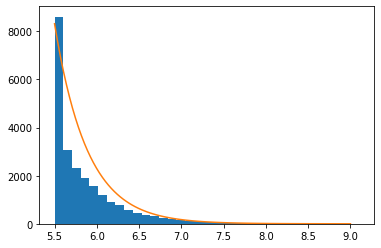

In [23]:
a = plt.hist(earthq["Magnitude"], bins = 35)

x = np.linspace(5.5, 9, 100)
y = [10**(10.08-1.12*(z)) for z in x]

b = plt.plot(x, y)

plt.show(a,b)